In [1]:
%pylab inline
import ThonkTools as TT
from uncertainties import unumpy as unp
from uncertainties import ufloat
from scipy import interpolate
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Daten einlesen
def read (path,offset=2, *kwargs):
    from numpy import array as array
    doc = []
    with open (path, 'r') as myfile:
        data = myfile.read().replace(',', '.').replace('\n', ',').replace('  ', ',').replace("\t",",")
        datarray = data.split(',')
        output = []
    for item in datarray:
        if item != '':
            output.append(int(item))
    dataset = array(output[offset:])
    dataset = [array(range(len(dataset))), dataset]
    return dataset

In [3]:
am_1 = read("Am_2_2.TKA")
am_2 = read("Am_1.TKA")
am_1_1 = am_1[0]
am_1_2 = am_1[1]
am_2_1 = am_2[0]
am_2_2 = am_2[1]

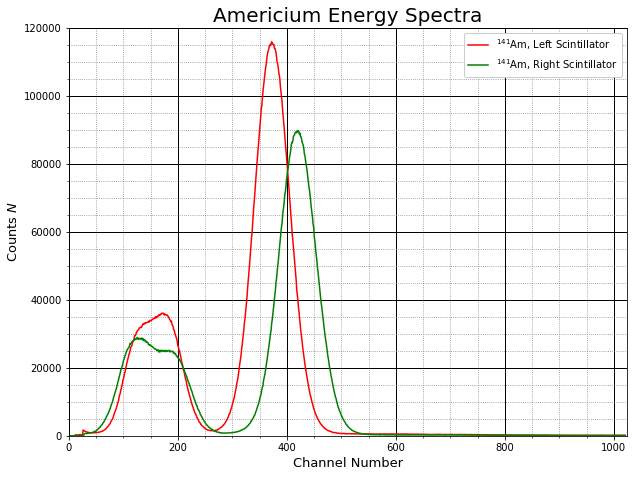

In [154]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(am_1_1,am_1_2, color='red', label=r'$^{141}$Am, Left Scintillator ')
plt.plot(am_2_1,am_2_2, color='green', label=r'$^{141}$Am, Right Scintillator ')

###   Label / Title

plt.ylabel(r'Counts $N$', fontsize=13)
plt.xlabel(r'Channel Number', fontsize=13)
plt.title('Americium Energy Spectra', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([0,1024])
axes.set_ylim([0,120000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(framealpha=1)
#plt.savefig('Americium_Energy_Spectra.png')
plt.show()

# Einzelne Peaks

In [42]:
#Thonk Tools Fit Funktionen
def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    return np.array(params), np.array(errors), R_2

def fit(x, y, func=lambda x: x, p0=None, r=None, d=None):
    """
        fit takes data points, calculates the curve fit, and gives back
        the values with which the curve can be plotted
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: the function type the curve_fit will be applied to.
        r: determines the size of steps in which the x-achse intervall is split.
        d: tuple which determines the start and end point of the x-achse intervall on which the
            will be drawn. If not given the curve will be drawn between the largest and the smalest
            given x-value.
        Returns:
        -----------
        xnew: x-value with which the fitted curve can be plotted.
        ynew: y-value with which the fitted curve can be plotted.
    """
    import numpy as np
    from scipy.optimize import curve_fit
    popt, pvoc = curve_fit(func, x, y, p0=p0)
    params = popt.copy()
    if d == None:
        if r == None:
            xnew = np.arange(min(x), max(x), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(x), max(x), r)
    else:
        if r == None:
            xnew = np.arange(min(d), max(d), np.abs((max(x) - min(x)) / 100))
        else:
            xnew = np.arange(min(d), max(d), r)
    ynew = func(xnew, *params)
    return xnew, ynew

In [43]:
#Funktionen für Dopple Gauß TT.fit/TT.fit_pm (aus dem Packet)
def gaus2fit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return fit(x, y, func=lambda x, mu, sigma, A, mu2, sigma2, B2, A2: A2 * np.e ** ((-1 * (x - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), r=r,
               d=d, p0=p0)
def gaus2fit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, A, mu2, sigma2, B2, A2: A2 * np.e ** ((-1 * (x - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), p0=p0)

In [46]:
Guess=[125,1,30000,185,1,1,35000] #Schätzung der Werte


#Gesammter Fit
gaus2_1 = gaus2fit(am_1_1[0:250], am_1_2[0:250], Guess, r=0.5, d=None)


#Einzelne Peaks
gaus2_1_value, gaus2_1_error ,R2 = gaus2fit_pm(am_1_1[0:250], am_1_2[0:250], Guess) #Berechnung der Parameter
mu, sigma, A, mu2, sigma2, B2, A2 = gaus2_1_value #Liste der Parameter
mu_R_1 = ufloat(gaus2_1_value[0], gaus2_1_error[0])
mu_R_2 = ufloat(gaus2_1_value[3], gaus2_1_error[3])

print(mu_R_1, mu_R_2)

xgaus = np.arange(0,250,0.5) 
ygaus1 = A * np.e ** ((-1 * (xgaus - mu) ** 2) / (2 * sigma ** 2)) + B2 #Parameter des 1.Peaks
ygaus2 = A2 * np.e ** ((-1 * (xgaus - mu2) ** 2) / (2 * sigma2 ** 2)) + B2 #Parameter des 2.Peaks

123.92+/-0.30 179.91+/-0.28


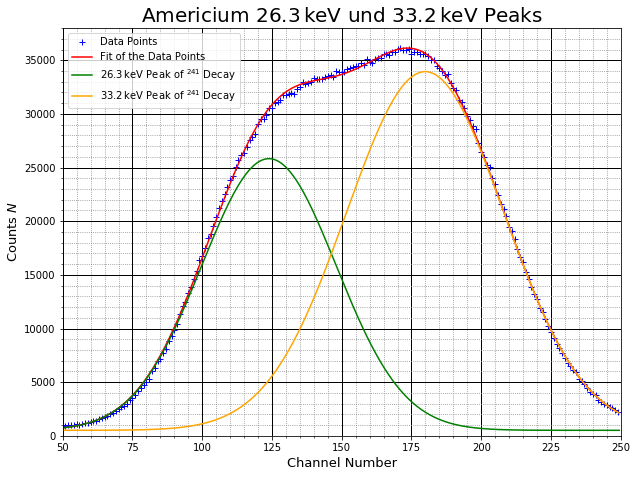

In [125]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(am_1_1[0:250], am_1_2[0:250],'+', label='Data Points', color='blue')
plt.plot(gaus2_1[0], gaus2_1[1], color='red', label='Fit of the Data Points')
plt.plot(xgaus, ygaus1, label=r'$26.3\,$keV Peak of $^{241}$ Decay', color='green')
plt.plot(xgaus, ygaus2, label=r'$33.2\,$keV Peak of $^{241}$ Decay', color='orange')

###   Label / Title

plt.ylabel(r'Counts $N$', fontsize=13)
plt.xlabel(r'Channel Number', fontsize=13)
plt.title(r'Americium $26.3\,$keV und $33.2\,$keV Peaks', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([50,250])
axes.set_ylim([0,38000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(loc=2)
#plt.savefig('kleine_Peaks1.png')
plt.show()

In [48]:
Guess2=[125,1,27000,175,1,1,25000] #Schätzung der Werte


#Gesammter Fit
gaus2_2 = gaus2fit(am_2_1[0:275], am_2_2[0:275], Guess2, r=0.5, d=None)


#Einzelne Peaks
gaus2_2_value, gaus2_2_error ,R2 = gaus2fit_pm(am_2_1[0:275], am_2_2[0:275], Guess) #Berechnung der Parameter
mu_2, sigma_2, A_2, mu2_2, sigma2_2, B2_2, A2_2 = gaus2_2_value #Liste der Parameter

mu_L_1 = ufloat(gaus2_2_value[0], gaus2_2_error[0])
mu_L_2 = ufloat(gaus2_2_value[3], gaus2_2_error[3])
print(mu_L_1, mu_L_2)

xgaus_2 = np.arange(0,275,0.5)
ygaus1_2 = A_2 * np.e ** ((-1 * (xgaus_2 - mu_2) ** 2) / (2 * sigma_2 ** 2)) + B2_2 #Parameter des 1.Peaks
ygaus2_2 = A2_2 * np.e ** ((-1 * (xgaus_2 - mu2_2) ** 2) / (2 * sigma2_2 ** 2)) + B2_2 #Parameter des 2.Peaks

120.61+/-0.23 191.25+/-0.29


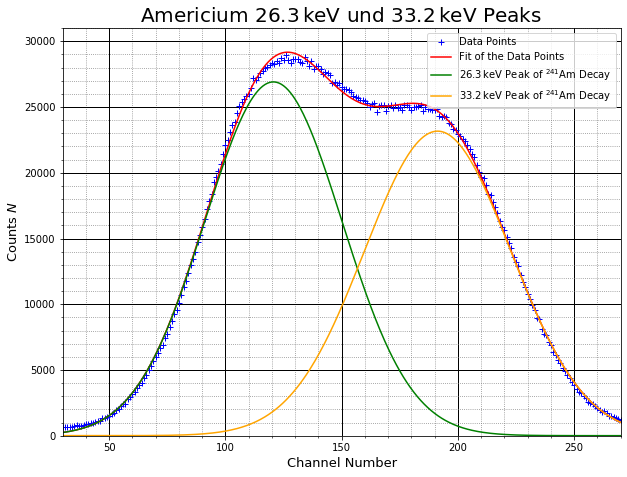

In [96]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(am_2_1[0:275], am_2_2[0:275],'+', label='Data Points', color='blue')
plt.plot(gaus2_2[0], gaus2_2[1], color='red', label='Fit of the Data Points')
plt.plot(xgaus_2, ygaus1_2, label=r'$26.3\,$keV Peak of $^{241}$Am Decay', color='green')
plt.plot(xgaus_2, ygaus2_2, label=r'$33.2\,$keV Peak of $^{241}$Am Decay', color='orange')

###   Label / Title

plt.ylabel(r'Counts $N$', fontsize=13)
plt.xlabel(r'Channel Number', fontsize=13)
plt.title(r'Americium $26.3\,$keV und $33.2\,$keV Peaks ', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

axes.set_xlim([30,270])
axes.set_ylim([0,31000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
#plt.savefig('kleine_Peaks2.png')
plt.show()

# Große Peaks

In [53]:
def gausfit(x, y, p0=None, r=None, d=None):
    import numpy as np
    return fit(x, y, func=lambda x, mu, sigma, A, B: B + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), r=r,
               d=d, p0=p0)
def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, A, B: B + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), p0=p0)

In [54]:
#1
start = 300
end = 550
x_2 = am_2_1[start:end]
y_2 = am_2_2[start:end]
p0 = [x_2[y_2.argmax(axis=0)],1,max(y_2),1]
xnew, ynew = gausfit(x_2,y_2,p0,r=0.5,d=None)
value,error, R2 = gausfit_pm(x_2,y_2,p0)
mu_L_3 = ufloat(value[0],error[0])
#2
start = 250
end = 500
x_2 = am_1_1[start:end]
y_2 = am_1_2[start:end]
p0 = [x_2[y_2.argmax(axis=0)],1,max(y_2),1]
xnew_2, ynew_2 = gausfit(x_2,y_2,p0,r=0.5,d=None)
value,error, R2 = gausfit_pm(x_2,y_2,p0)
mu_R_3 = ufloat(value[0],error[0])
print(mu_R_3,mu_L_3)

372.833+/-0.022 419.534+/-0.023


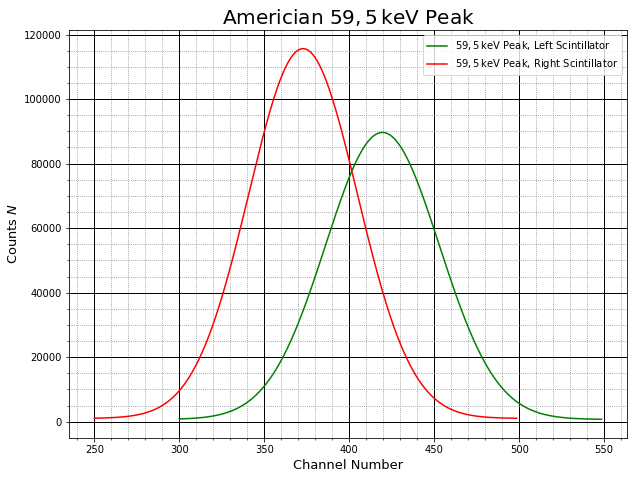

In [55]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

#plt.plot(x,y,'x', label='Data Points', color='red')
#plt.plot(x_2,y_2,'x', label='Data Points', color='blue')
plt.plot(xnew, ynew, label=r'$59,5\,$keV Peak, Right Scintillator', color='green')
plt.plot(xnew_2, ynew_2, label=r'$59,5\,$keV Peak, Left Scintillator', color='red')

###   Label / Title

plt.ylabel(r'Counts $N$', fontsize=13)
plt.xlabel(r'Channel Number', fontsize=13)
plt.title(r'Americian $59,5\,$keV Peak', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([30,270])
#axes.set_ylim([0,31000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
#plt.savefig('AmPeaks3.png')
plt.show()

# Energie Eichung

In [62]:
def unp_v(x):
    return unp.nominal_values(x)

In [66]:
#Rechts
print(mu_R_1,mu_R_2,mu_R_3)
unp_v([mu_R_1,mu_R_2,mu_R_3])

123.92+/-0.30 179.91+/-0.28 372.833+/-0.022


array([123.92367313, 179.91429454, 372.83251644])

In [104]:
#Links
print(mu_L_1,mu_L_2,mu_L_3)
unp_v([mu_L_1,mu_L_2,mu_L_3])

120.61+/-0.23 191.25+/-0.29 419.534+/-0.023


array([120.61281889, 191.24779276, 419.53416619])

In [180]:
x_TL ,y_TL = TT.linfit(unp_v([mu_L_1,mu_L_2,mu_L_3]), [26.3,33.2,59.5])
Rvalues, RR2 = TT.linfit_pm(unp_v([mu_L_1,mu_L_2,mu_L_3]),[26.3,33.2,59.5])
#plt.plot(x_TL ,y_TL)
#plt.plot(unp_v([mu_L_1,mu_L_2,mu_L_3]),[26.3,33.2,59.5],'x')
print(Rvalues,RR2)
def RCh_zu_En(x):
    return x*Rvalues[0] + Rvalues[1]

print(LCh_zu_En(np.array([120.61281889, 191.24779276, 419.53416619])))
print()
x_TR ,y_TR = TT.linfit(unp_v([mu_R_1,mu_R_2,mu_R_3]), [26.3,33.2,59.5])
Lvalues, LR2 = TT.linfit_pm(unp_v([mu_R_1,mu_R_2,mu_R_3]),[26.3,33.2,59.5])
#plt.plot(x_TR ,y_TR)
#plt.plot(unp_v([mu_R_1,mu_R_2,mu_R_3]),[26.3,33.2,59.5],'x')
print(Lvalues,LR2)
def LCh_zu_En(x):
    return x*Lvalues[0] + Lvalues[1]

print(RCh_zu_En(array([123.92367313, 179.91429454, 372.83251644])))

[0.11208338520151274+/-0.0033412025317610203
 12.34093246011272+/-0.919351147037457] 0.9991121545641167
[25.58920781691076+/-0.6634517885045702
 35.06436457990915+/-0.7526188447337975
 65.68728487838084+/-1.1686194678466322]

[0.13414256768094684+/-0.0023941674118904328
 9.409894595769153+/-0.5973120904649856] 0.9996815527577266
[26.230717251128866+/-1.0082893043873484
 32.50633563829796+/-1.0984370370564962
 54.129263015906574+/-1.5482239225377008]


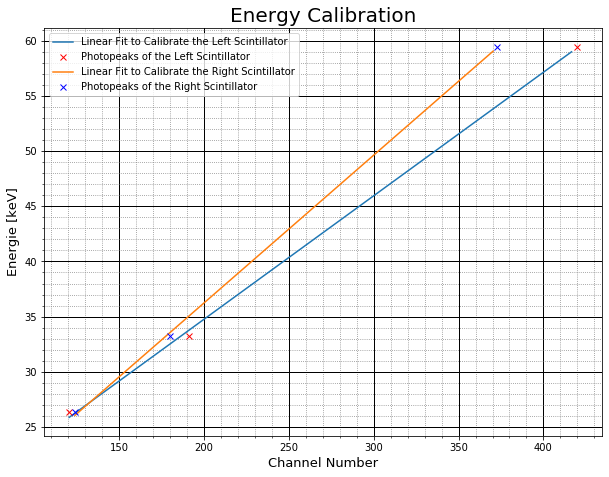

In [156]:
### FigureSize

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot

plt.plot(x_TL ,y_TL, label='Linear Fit to Calibrate the Left Scintillator')
plt.plot(unp_v([mu_L_1,mu_L_2,mu_L_3]),[26.3,33.2,59.5],'x',color='red', label='Photopeaks of the Left Scintillator')
plt.plot(x_TR ,y_TR, label='Linear Fit to Calibrate the Right Scintillator')
plt.plot(unp_v([mu_R_1,mu_R_2,mu_R_3]),[26.3,33.2,59.5],'x',color='blue', label='Photopeaks of the Right Scintillator')

###   Label / Title

plt.ylabel(r'Energie [keV]', fontsize=13)
plt.xlabel(r'Channel Number', fontsize=13)
plt.title(r'Energy Calibration', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([30,270])
#axes.set_ylim([0,31000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend()
#plt.savefig('EnergyCalib.png')
plt.show()

In [168]:
#14.4, 122.1
def REn_zu_Ch(x):
    return (x - Rvalues[1]) / Rvalues[0]
def LEn_zu_Ch(x):
    return (x - Lvalues[1]) / Lvalues[0]
REn_zu_Ch()

18.370854308025397+/-8.220646785201444

In [183]:
sqrt(50)

7.0710678118654755

In [189]:
x = ufloat(323,2.1)+ufloat(2,1)

In [190]:
x

325.0+/-2.3259406699226015